In [104]:
import pandas as pd
import numpy as np

In [105]:
df = pd.read_feather("data/dataset.feather")

In [153]:
label_cols = ["kl_div_blowup_step", "plateau_length"]
# label_cols = ['kl_div_blowup_step']
exclude_cols = [
    "id",
    "start_prompt",
    "end_prompt",
    "perturbation_type",
    "final_kl_div",
    "perturbation_type",
    "start_act_top_1_sae_feature_id",
    "start_act_top_2_sae_feature_id",
    "start_act_top_3_sae_feature_id",
    "end_act_top_1_sae_feature_id",
    "end_act_top_2_sae_feature_id",
    "end_act_top_3_sae_feature_id",
    "max_feature_activation_count",
    "kl_div_blowup_step",
    "plateau_length",
]
exclude_cols = set(exclude_cols) | set(label_cols)
feature_cols = [c for c in df.columns if c not in exclude_cols]

## Correlations

In [108]:
# TODO: Fix this
df[feature_cols + label_cols].corr().filter(label_cols).drop(label_cols)

,kl_div_blowup_step,plateau_length
prompts_cos_sim,-0.014816,0.034132
prompts_token_sim,0.029218,0.039694
final_l2_norm,-0.216205,-0.311097
final_cos_sim,0.181529,0.268958
total_unique_active_features,-0.075158,-0.133815
avg_feature_activation_count,0.174676,0.207678
avg_active_features,-0.063140,-0.121803
std_active_features,-0.067059,-0.121700
avg_feature_activation,0.087992,0.065763
std_feature_activation,-0.116182,-0.149961


## Modelling

In [154]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [165]:
X, y = df[feature_cols].to_numpy(), df[label_cols].to_numpy()

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [167]:
# Comment out this block if you don't want to normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [168]:
model = MultiOutputRegressor(
    xgb.XGBRegressor(n_estimators=300, max_depth=10, learning_rate=0.1, random_state=42)
)

# model = xgb.XGBRegressor(
#     n_estimators=300,
#     max_depth=10,
#     learning_rate=0.1,
#     random_state=42
# )

In [169]:
model.fit(X_train_scaled, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [170]:
y_pred = model.predict(X_test_scaled)

In [171]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput="raw_values")
r2 = r2_score(y_test, y_pred, multioutput="raw_values")

In [172]:
# Print results
for i, col in enumerate(label_cols):
    print(f"Target: {col}")
    print(f"MSE: {mse[i]:.4f}")
    print(f"R-squared: {r2[i]:.4f}")
    print()

Target: kl_div_blowup_step
MSE: 38.9031
R-squared: 0.6227

Target: plateau_length
MSE: 51.2871
R-squared: 0.6564



In [ ]:
# Target: kl_div_blowup_step
# MSE: 38.9031
# R-squared: 0.6227

# Target: plateau_length
# MSE: 51.2871
# R-squared: 0.6564

In [174]:
# Feature importance
feature_importance = np.mean(
    [estimator.feature_importances_ for estimator in model.estimators_], axis=0
)
feature_importance_df = pd.DataFrame(
    {"feature": feature_cols, "importance": feature_importance}
).sort_values("importance", ascending=False)

print("Feature Importance:")
print(feature_importance_df.head(10))

Feature Importance:
                                       feature  importance
5                 avg_feature_activation_count    0.127103
10  start_act_top_1_sae_feature_act_norm_start    0.093179
12        start_act_top_1_sae_feature_sparsity    0.077805
18        start_act_top_3_sae_feature_sparsity    0.070012
15        start_act_top_2_sae_feature_sparsity    0.068349
19    end_act_top_1_sae_feature_act_norm_start    0.062343
13  start_act_top_2_sae_feature_act_norm_start    0.061498
21          end_act_top_1_sae_feature_sparsity    0.043991
16  start_act_top_3_sae_feature_act_norm_start    0.039441
24          end_act_top_2_sae_feature_sparsity    0.032995


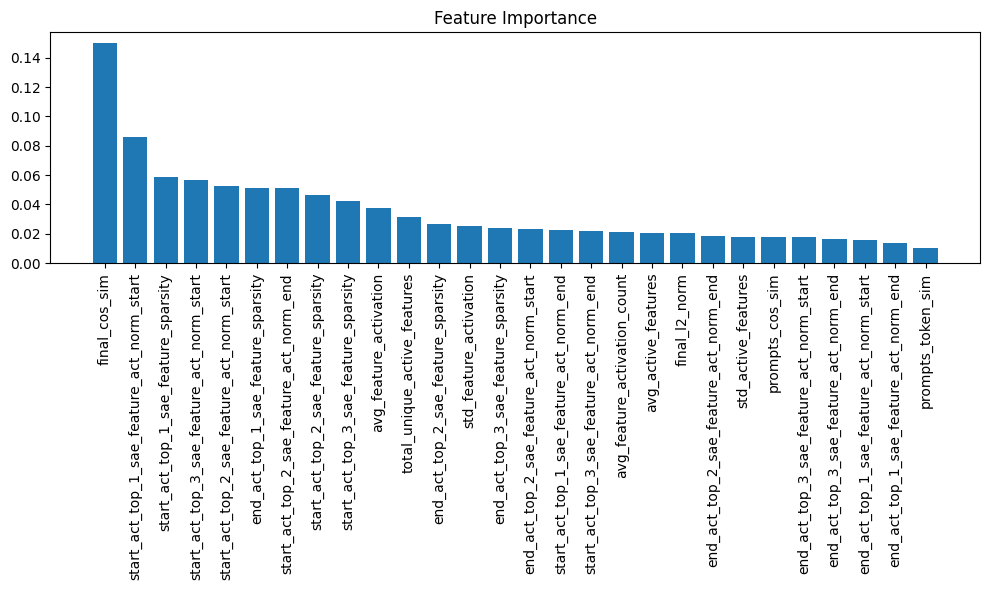

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df["feature"], feature_importance_df["importance"])
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [177]:
! du -sh observations

459M	observations
